## Chest CT Registration

Authors: **Muhammad Zain Amin**, **Mohammad Imran Hossain**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

In [1]:
# Install Dependencies
!pip install simpleITK
!pip install xlsxwriter
!pip install voxelmorph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19532 sha256=c9ee46c8126886b90c849eca8a9da19fe4ab920913a6533823afaf7f978fdf1e
  Stored in directory: /root/.cache/pip/wheels/aa/08/d0/914025beb5a12a855b8aafd22eeedc547198684a3f4409f66c
Successfully built pystrum


In [2]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import zoom
import neurite as ne
import voxelmorph as vxm
import keras.backend as K
import tensorflow as tf
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
new_z_dim = 128
data_file = "/content/drive/MyDrive/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed/"
data = []
list_id = [1, 2, 3, 4]


for val_i in list_id:

  name = "copd" + str(val_i)
  print(name)

  inhale_imgPath = data_file + 'copd{}/'.format(val_i) + '{0}/seg_{0}_iBHCT.nii.gz'.format(name)
  exhale_imgPath = data_file + 'copd{}/'.format(val_i) + '{0}/seg_{0}_eBHCT.nii.gz'.format(name)

  inhale_data = nib.load(inhale_imgPath).get_fdata()
  exhale_data = nib.load(exhale_imgPath).get_fdata()

  mean = np.mean(inhale_data[np.nonzero(inhale_data)])
  std = np.std(inhale_data[np.nonzero(inhale_data)])
  inhale_data = (inhale_data - mean) / std

  mean = np.mean(exhale_data[np.nonzero(exhale_data)])
  std = np.std(exhale_data[np.nonzero(exhale_data)])
  exhale_data = (exhale_data - mean) / std

  factor = new_z_dim / inhale_data.shape[2]

  if(val_i == 0):
    new_inhale = np.expand_dims(zoom(inhale_data, (1, 1, factor)), axis=0)
    new_exhale = np.expand_dims(zoom(exhale_data, (1, 1, factor)), axis=0)
  else :
    new_inhale = np.expand_dims(zoom(inhale_data, (0.5, 0.5, factor)), axis=0)
    new_exhale = np.expand_dims(zoom(exhale_data, (0.5, 0.5, factor)), axis=0)

  data.append(np.concatenate((new_inhale, new_exhale), axis=0))

np.save('/content/drive/MyDrive/MIRA_Final_Project/dataset/saved_data/pre_VM.npy', data)

copd1
copd2
copd3
copd4


In [5]:
# load data numpy file
data = np.load('/content/drive/MyDrive/MIRA_Final_Project/dataset/saved_data/pre_VM.npy')
print(data.shape)

# split into training and validation
split_per = 75
train_split = int((split_per/100) * len(data))
data_train = data[:train_split, ...]
data_val = data[train_split:, ...]
print('train shape:', data_train.shape)

(4, 2, 256, 256, 128)
train shape: (3, 2, 256, 256, 128)


In [6]:
BATCH_SIZE_ = 1
def vxm_data_generator(x_data, batch_size):
    # preliminary sizing
    vol_shape = x_data.shape[2:]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation.
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs
        idx = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx, 0, ..., np.newaxis]
        moving_images = x_data[idx, 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        outputs = [fixed_images, zero_phi]
        yield inputs, outputs

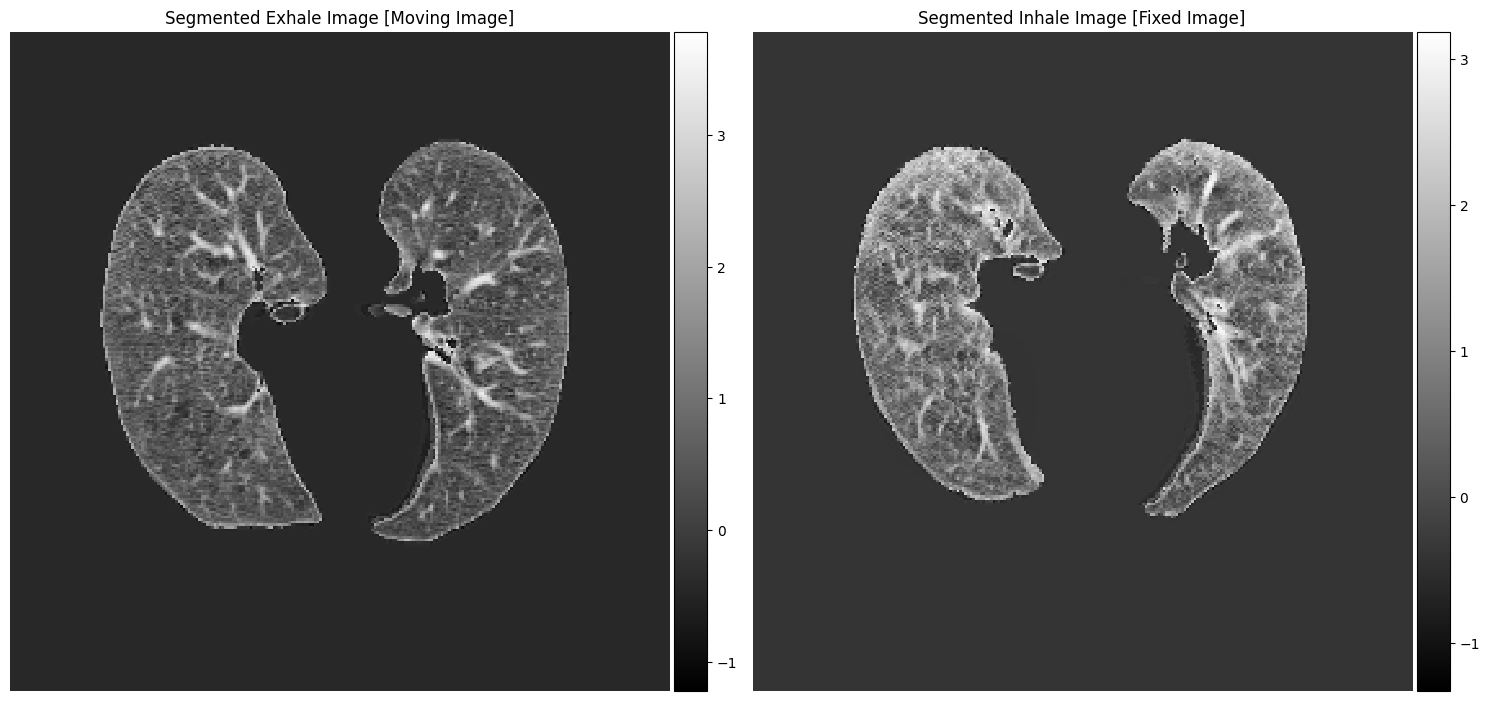

(<Figure size 1500x750 with 4 Axes>,
 array([<Axes: title={'center': 'Segmented Exhale Image [Moving Image]'}>,
        <Axes: title={'center': 'Segmented Inhale Image [Fixed Image]'}>],
       dtype=object))

In [7]:
# create the data generator
train_generator = vxm_data_generator(data_train, BATCH_SIZE_)

# visualize a sample
input_sample, output_sample = next(train_generator)

# Rotate the images by 90 degrees clockwise
input_sample_rotated = [np.rot90(sample, k=1, axes=(1, 2)) for sample in input_sample]
output_sample_rotated = [np.rot90(sample, k=1, axes=(1, 2)) for sample in output_sample]

slices_2d = [
    input_sample_rotated[1][0, :, :, 60, 0],
    input_sample_rotated[0][0, :, :, 60, 0],
]

titles = ['Segmented Exhale Image [Moving Image]', 'Segmented Inhale Image [Fixed Image]']
ne.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True)

In [8]:
# configure unet features
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model using VxmDense
inshape = data_train.shape[2:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

In [9]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 256, 256, 128, 1), (None, 256, 256, 128, 1)
output shape: (None, 256, 256, 128, 1), (None, 256, 256, 128, 3)


In [10]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [11]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [12]:
# train the model
nb_epochs = 100

earlyStopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('/content/drive/MyDrive/MIRA_Final_Project/dataset/results/Pre_VM_train_{0}_test_{1}_epoch_{2}.keras'.format(split_per, (100-split_per),nb_epochs), save_best_only=True, monitor='loss', mode='min', verbose=1)

reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')
steps_per_epoch = data_train.shape[0]

start_time = time.time()
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=1, callbacks=[mcp_save, reduce_lr_loss]);
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.7278 - vxm_dense_transformer_loss: 0.7278 - vxm_dense_flow_loss: 0.0013
Epoch 1: loss improved from inf to 0.72782, saving model to /content/drive/MyDrive/MIRA_Final_Project/dataset/results/Pre_VM_train_75_test_25_epoch_100.keras
3/3 [==============================] - 70s 2s/step - loss: 0.7278 - vxm_dense_transformer_loss: 0.7278 - vxm_dense_flow_loss: 0.0013 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.5246 - vxm_dense_transformer_loss: 0.5242 - vxm_dense_flow_loss: 0.0079
Epoch 2: loss improved from 0.72782 to 0.52461, saving model to /content/drive/MyDrive/MIRA_Final_Project/dataset/results/Pre_VM_train_75_test_25_epoch_100.keras
3/3 [==============================] - 6s 2s/step - loss: 0.5246 - vxm_dense_transformer_loss: 0.5242 - vxm_dense_flow_loss: 0.0079 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.2818 - vxm_dense_transformer_loss: 0.2

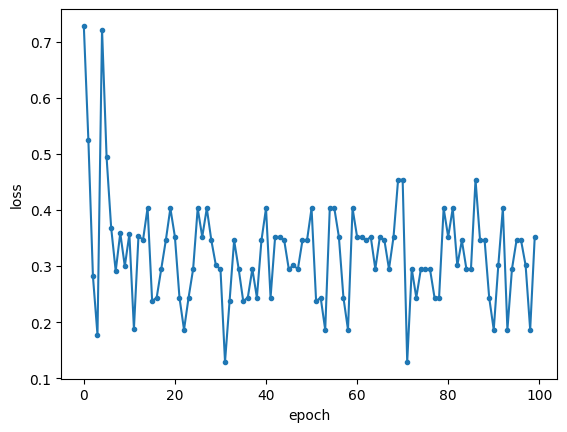

In [13]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    #plt.plot(hist.epoch, hist.history['disp_loss'], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

1/1 [==============================] - 1s 1s/step


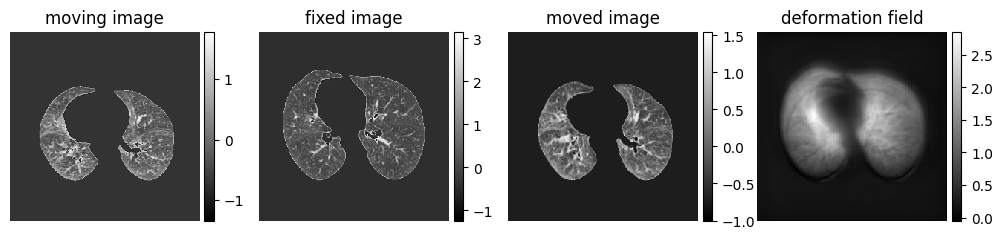

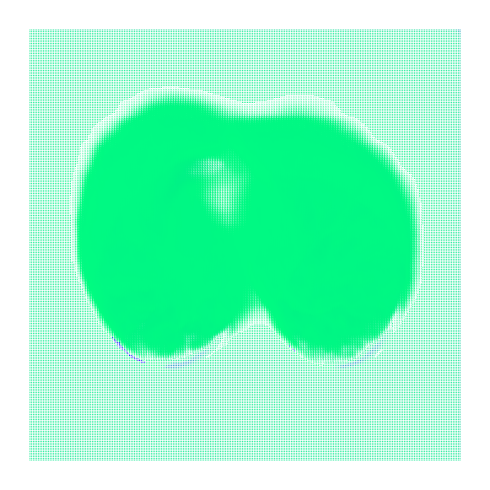

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [14]:
nb_epochs = 2

# load model
vxm_model.load_weights('/content/drive/MyDrive/MIRA_Final_Project/dataset/results/Pre_VM_train_75_test_25_epoch_100.keras')

# data generator on val data (copd4)
val_generator = vxm_data_generator(data_val, BATCH_SIZE_)
val_input, _ = next(val_generator)

# predict on validation data (copd4)
val_pred = vxm_model.predict(val_input)

# visualize
slices_2d = [f[0, :, :, 60, 0] for f in val_input + val_pred]
titles = ['moving image', 'fixed image', 'moved image', 'deformation field']

# Rotate all the plotted images by 90 degrees clockwise
slices_2d_rotated = [np.rot90(f, k=-1) for f in slices_2d]

ne.plot.slices(slices_2d_rotated, titles=titles, cmaps=['gray'], do_colorbars=True, width=10)

# Visualize the flow
val_pred_flow_rotated = np.rot90(val_pred[1][0, :, :, 60, 0:2].squeeze(), k=-1)
ne.plot.flow([val_pred_flow_rotated], width=5)

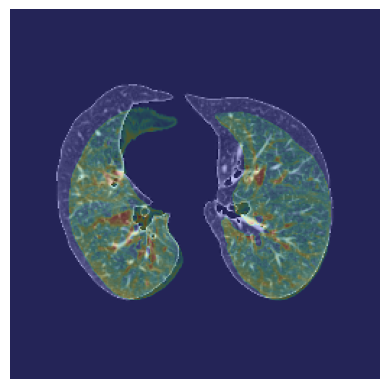

In [15]:
# Rotate images by 90 degrees clockwise
fixed_rotated = np.rot90(slices_2d[1], k=-1)  # Rotate fixed image
moved_rotated = np.rot90(slices_2d[2], k=-1)  # Rotate moved image

plt.figure()
plt.axis('off')

# Display fixed image in grayscale
plt.imshow(fixed_rotated, cmap='gray', alpha=1)

# Display moved image in 'jet' colormap with 20% transparency
plt.imshow(moved_rotated, cmap='jet', alpha=0.2)

plt.show()

In [16]:
def calculateTRE(landmarks_fixed, landmarks_moving, voxel_dimensions):

    # Taking into account the voxel size
    landmarks_moving = voxel_dimensions * landmarks_moving
    landmarks_fixed  = voxel_dimensions * landmarks_fixed

    # Calculated the squared difference (euclidean)
    tre = np.sqrt(np.sum((landmarks_fixed - landmarks_moving) ** 2,axis =1))

    # Calculating the mean and std tre
    mean_tre = np.mean(tre)
    std_tre = np.std(tre)

    return mean_tre, std_tre

In [17]:
def point_spatial_transformer(surface_points, trf, single=False):

    surface_pts_D = surface_points.get_shape().as_list()[-1]
    trf_D = trf.get_shape().as_list()[-1]
    assert surface_pts_D in [trf_D, trf_D + 1]

    if surface_pts_D == trf_D + 1:
        li_surface_pts = K.expand_dims(surface_points[..., -1], -1)
        surface_points = surface_points[..., :-1]

    fn = lambda x: ne.utils.interpn(x[0], x[1])
    diff = tf.map_fn(fn, [trf, surface_points], dtype=tf.float32)
    ret = surface_points + diff

    if surface_pts_D == trf_D + 1:
        ret = tf.concat((ret, li_surface_pts), -1)

    return ret

In [18]:
def after_registration(id, param, landmarks_moving, landmarks_fixed, voxel_spacing):

  # based on which COPD data you have selected, the dimensions are assigned
  if id == "1":
    sample_data = data[0:1,...]
    z_dim = 121

  elif id == "2":
    sample_data = data[1:2,...]
    z_dim = 102

  elif id == "3":
    sample_data = data[2:3,...]
    z_dim = 126

  elif id == "4":
    sample_data = data[3:4,...]
    z_dim = 126

  # data augmentation done on the data
  val_generator = vxm_data_generator(sample_data, batch_size = 1)
  val_input, _ = next(val_generator)

  val_pred = vxm_model.predict(val_input)

  out_results = val_pred[1].squeeze()
  factor = z_dim / out_results.shape[2]

  new_out = zoom(out_results,(2, 2, factor,1),order=1)

  data_tf = tf.convert_to_tensor(new_out, dtype=tf.float32)
  data_tf = K.expand_dims(data_tf, 0)

  # Transforming the fixed (inhale) landmark points and then comparing with the exisiting moving (exhale) landmark points
  landmarksF = tf.convert_to_tensor(landmarks_fixed, dtype=tf.float32)
  landmarksF = K.expand_dims(landmarksF, 0)

  transformed_points = point_spatial_transformer(landmarksF, data_tf)

  def tensor_to_array(array_value):
      return array_value.numpy()

  array = tensor_to_array(transformed_points)
  array = array.squeeze()

  # Calculating the TRE
  mean_tre , std_tre = calculateTRE(array, landmarks_moving, voxel_spacing)
  print('COPD{0} & {1:.2f} ({2:.2f})'.format(id, mean_tre , std_tre))

In [19]:
def save_landmark_points(id, param, landmarks_fixed, voxel_spacing):

   # based on which COPD data you have selected, the dimensions are assigned
  if id == "1":
    sample_data = data[0:1,...]
    z_dim = 121

  elif id == "2":
    sample_data = data[1:2,...]
    z_dim = 102

  elif id == "3":
    sample_data = data[2:3,...]
    z_dim = 126

  elif id == "4":
    sample_data = data[3:4,...]
    z_dim = 126


  # data augmentation done on the data
  val_generator = vxm_data_generator(sample_data, batch_size = 1)
  val_input, _ = next(val_generator)

  val_pred = vxm_model.predict(val_input)

  out_results = val_pred[1].squeeze()
  factor = z_dim / out_results.shape[2]
  if(id == 0):
    new_out = zoom(out_results,(1, 1, factor,1),order=1)
  else:
    new_out = zoom(out_results,(2, 2, factor,1),order=1)


  data_tf = tf.convert_to_tensor(new_out, dtype=tf.float32)
  data_tf = K.expand_dims(data_tf, 0)

  # Transforming the fixed (inhale) landmark points and then comparing with the exisiting moving (exhale) landmark points
  landmarksF = tf.convert_to_tensor(landmarks_fixed, dtype=tf.float32)
  landmarksF = K.expand_dims(landmarksF, 0)

  transformed_points = point_spatial_transformer(landmarksF, data_tf)

  def tensor_to_array(array_value):
      return array_value.numpy()

  array = tensor_to_array(transformed_points)
  array = array.squeeze()

  np.savetxt('/content/drive/MyDrive/MIRA_Final_Project/dataset/saved_data/pre_copd{0}_300_iBH_xyz_r1.txt'.format(id), array)

In [20]:
data_file = "/content/drive/MyDrive/MIRA_Final_Project/dataset/results_affine_bspline_preprocessed/"

list_id = [1, 2, 3, 4]

for val_i in list_id:

  id = str(val_i)

  # Set this path to the file containing all the images
  path_to_data_dir = data_file

  path_to_data_dir = "{0}copd{1}/".format(path_to_data_dir,id)

  # Setting up the input parameters
  param = {}

  # Input Images
  param['inhale'] = path_to_data_dir + 'copd' + id + '/' + 'copd' + id + '_iBHCT.nii.gz'

  # Landmark Images Inhale and Exhale
  param['landmarks_inhale'] = path_to_data_dir + 'copd' + id + '/' + 'copd' + id + '_reg_transformed_points.txt'
  param['landmarks_exhale'] = path_to_data_dir + 'copd' + id + '/' + 'copd' + id + '_300_eBH_xyz_r1.txt'

  # Loading the inhale and exhale landmarks
  landmarks_moving = np.loadtxt(param['landmarks_exhale'])
  landmarks_fixed = np.loadtxt(param['landmarks_inhale'])

  # Getting the voxel spacing in the image
  voxel_spacing = nib.load(param['inhale']).header.get_zooms()

  after_registration(id, param, landmarks_moving, landmarks_fixed, voxel_spacing)

1/1 [==============================] - 0s 499ms/step
COPD1 & 7.47 (2.81)
1/1 [==============================] - 0s 495ms/step
COPD2 & 7.00 (3.45)
1/1 [==============================] - 0s 487ms/step
COPD3 & 3.88 (1.64)
1/1 [==============================] - 1s 508ms/step
COPD4 & 4.07 (1.91)
